In [271]:
import os
import torch

import torch.nn as nn
import torchvision
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

from scipy.spatial.distance import pdist, squareform


In [272]:

base_dir = os.path.abspath('../..')
save_dir = os.path.join(base_dir,'results')
data_dir = os.path.join(base_dir,'data')
results_dir = os.path.join(base_dir,'results')

In [273]:
class TripletLabelModel(nn.Module):
    def __init__(self, encoded_space_dim=64, num_classes=4):
        super().__init__()
        ""
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
    
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(32*4*4, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )

        ## triplet projection module
        self.decoder_triplet_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 32),
            nn.ReLU(True)
         
        )
        ##labeling module
        self.decoder_labels_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 32),
            nn.ReLU(True),
            nn.Linear(32, 16),
            nn.ReLU(True),
            nn.Linear(16, num_classes),
        )

        ### initialize weights using xavier initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    
        
    def forward(self, x, y=None):
        batch_s = x.size(0)
        img_features = self.encoder_cnn(x)
        img_features = self.flatten(img_features)
        
        enc_latent = self.encoder_lin(img_features)

        triplet_latent = self.decoder_triplet_lin(enc_latent)
        label = self.decoder_labels_lin(enc_latent)
        # label = F.softmax(label,dim=1)
        return enc_latent, label

In [274]:
v_ims = np.load(os.path.join(data_dir,'validation_set.npy')) ## validation images
v_labels = np.load(os.path.join(data_dir,'validation_labs.npy')) ### validation labels

In [275]:
nn_model = TripletLabelModel()

model_list = os.listdir(results_dir)
model_list = sorted(model_list)

1.0
0.9979166666666667
0.23958333333333334
1.0
1.0
0.225
1.0
1.0
0.35


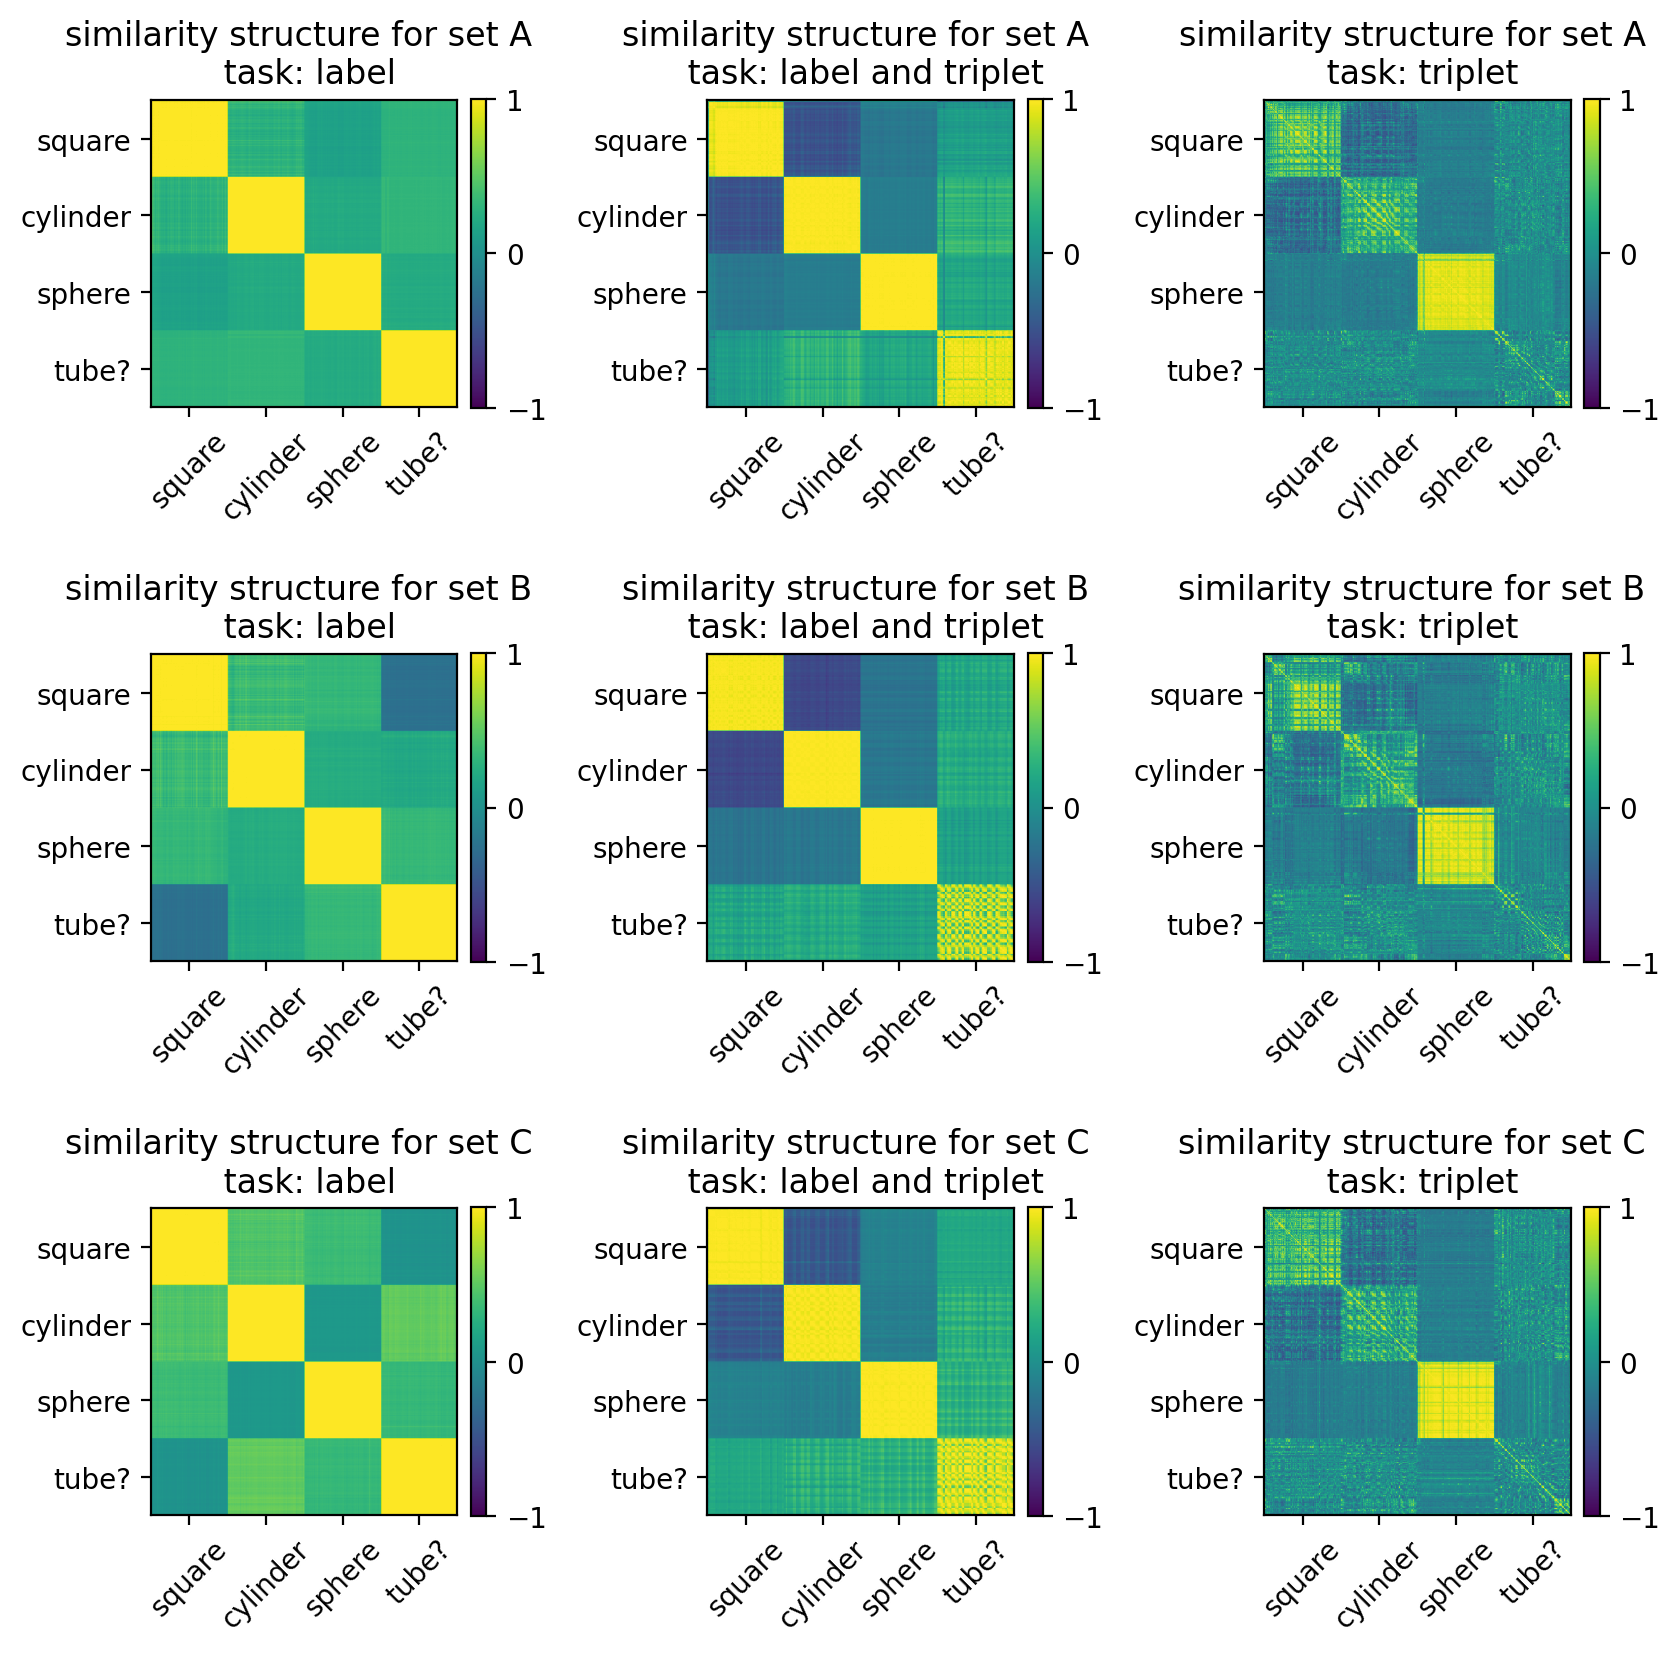

In [293]:
latents_df =pd.DataFrame(columns=['dataset','task','latent'])
fig, axes = plt.subplots(3,3,figsize=(8.5,8.5))

for i, this_model in enumerate(model_list):
    ax = axes.flatten()[i]
    nn_model.load_state_dict(torch.load(os.path.join(results_dir,this_model)))
    ### pass v_ims through the model but make sure to transpose the image dimensions first
    v_ims_t = torch.from_numpy(v_ims.transpose(0,3,1,2)).float()
    v_ims_t = v_ims_t/255.0

    ### now pass v_ims through the model
    latents, labels = nn_model(v_ims_t)

    ### do an argmax on the labels to get the predicted labels
    pred_labels = torch.argmax(labels,dim=1)
    pred_labels = pred_labels.detach().numpy()

    correct = 0
    for j in range(len(pred_labels)):
        if pred_labels[j] == v_labels[j]:
            correct += 1
    print(correct/len(pred_labels))


    # Compute pairwise cosine similarities
    cos_sim = cosine_similarity(latents.detach().numpy())

    # Plot heatmap
    im = ax.imshow(cos_sim, cmap='viridis', vmin=-1, vmax=1)
    cbar = ax.figure.colorbar(im, ax=ax,fraction=0.046, pad=0.04)
    cbar.set_ticks([-1,0,1])


    ax.set_xticks([60,180,300,420],['square','cylinder','sphere','tube?'], rotation=45)
    ax.set_yticks([60,180,300,420],['square','cylinder','sphere','tube?'])



    task_string = this_model.split('_', 2)[2]
    task_string = task_string.rsplit('_', 1)[0].replace('_', ' ')


   
    ax.set_title(f'similarity structure for set {this_model.split("_")[1]} \n task: {task_string}')
    fig.tight_layout()

    latents_df.loc[i,'dataset'] = this_model.split("_")[1]
    latents_df.loc[i,'task'] = task_string.replace(' ', '_')
    latents_df.loc[i,'latent'] = latents.detach().numpy()
    

plt.show()




In [294]:
# latents_df = latents_df[latents_df['task']!='label']


In [295]:
latents_df

,dataset,task,latent
0,A,label,"[[-0.7834582, 1.3033897, 0.57662594, -0.838784..."
1,A,label_and_triplet,"[[-1.1247354, -0.57989347, 2.874291, 1.8969971..."
2,A,triplet,"[[-0.33464885, 0.4688541, -0.17385682, -0.8210..."
3,B,label,"[[2.0292954, -1.7205865, 1.807349, 0.052920043..."
4,B,label_and_triplet,"[[1.510348, 0.6277172, -1.7382647, -2.3525982,..."
5,B,triplet,"[[-1.341064, 0.97320086, -0.075968295, -1.2117..."
6,C,label,"[[0.4540207, 2.1368616, -0.8538073, 1.0479497,..."
7,C,label_and_triplet,"[[0.6844812, -0.21418872, 2.0833309, -0.734603..."
8,C,triplet,"[[-0.60117674, -0.30274966, -0.49074966, -0.73..."


In [297]:
for this_task in latents_df['task'].unique():
   ds = latents_df[latents_df['task']==this_task]
   distA = pdist(ds[ds.dataset=='A']['latent'].values[0], metric='cosine')
   distB = pdist(ds[ds.dataset=='B']['latent'].values[0], metric='cosine')
   distC = pdist(ds[ds.dataset=='C']['latent'].values[0], metric='cosine')
   ### compute distance matrices and get lower triangles
   dmatA = np.tril(squareform(distA),k=-1).flatten()
   dmatB = np.tril(squareform(distB),k=-1).flatten()
   dmatC = np.tril(squareform(distC),k=-1).flatten()

   AB_sim = np.corrcoef(dmatA,dmatB)[0,1]
   AC_sim = np.corrcoef(dmatA,dmatC)[0,1]
   BC_sim = np.corrcoef(dmatB,dmatC)[0,1]
   print(f'AB similarity for {this_task} is {AB_sim}')
   print(f'AC similarity for {this_task} is {AC_sim}')
   print(f'BC similarity for {this_task} is {BC_sim}')






AB similarity for label is 0.9284559658540353
AC similarity for label is 0.9472026188550396
BC similarity for label is 0.9650376252883537
AB similarity for label_and_triplet is 0.9877161357997191
AC similarity for label_and_triplet is 0.990683016440644
BC similarity for label_and_triplet is 0.9930434364065386
AB similarity for triplet is 0.9476065616968868
AC similarity for triplet is 0.9526374937803936
BC similarity for triplet is 0.9437226300749537
